<a href="https://colab.research.google.com/github/2303a52239/Explainable-AI-/blob/main/Explainable_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install shap lime scikit-learn matplotlib seaborn imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load the dataset
url = '/content/HAM10000_metadata.csv'
df = pd.read_csv(url)

# Preprocessing
df = df.dropna()  # Drop rows with missing values
df['dx'] = LabelEncoder().fit_transform(df['dx'])  # Encode labels

# Drop 'image_id' and 'lesion_id' as they are not features
df = df.drop(['image_id', 'lesion_id'], axis=1)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['dx_type', 'sex', 'localization'], drop_first=True)

X = df.drop('dx', axis=1)
y = df['dx']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.17      0.48      0.25        65
           1       0.18      0.45      0.25        91
           2       0.44      0.29      0.35       225
           3       0.23      0.52      0.32        29
           4       0.32      0.41      0.36       225
           5       0.97      0.75      0.84      1336
           6       0.20      0.43      0.28        21

    accuracy                           0.63      1992
   macro avg       0.36      0.48      0.38      1992
weighted avg       0.76      0.63      0.67      1992



/tmp/ipython-input-982812095.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


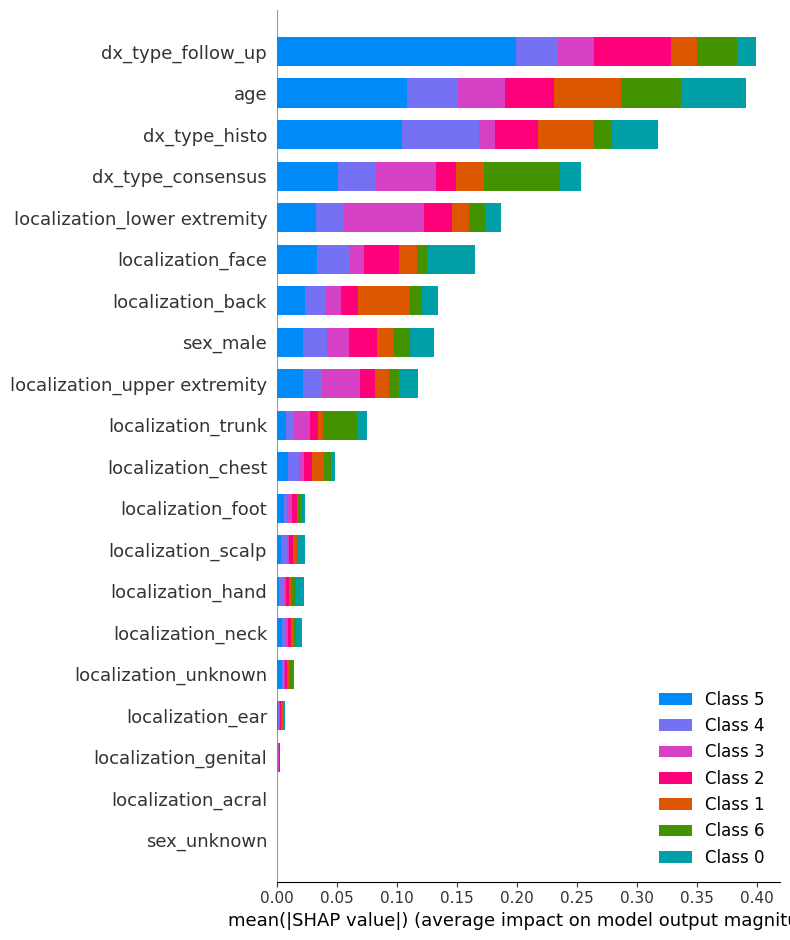

In [ ]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


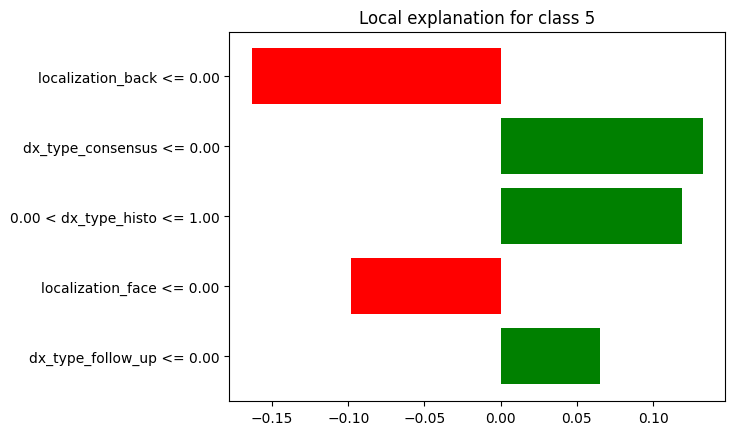

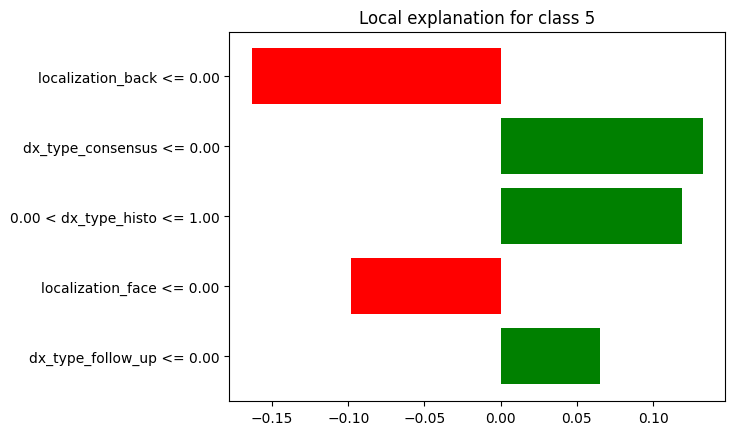

In [ ]:
# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_res.values,
    training_labels=y_train_res.values,
    mode="classification",
    class_names=df['dx'].unique(),
    feature_names=X.columns,
    discretize_continuous=True
)

# Select a random instance from the test set
i = 25
exp = lime_explainer.explain_instance(X_test.iloc[i].values, clf.predict_proba, num_features=5)

# Plot LIME explanation
exp.as_pyplot_figure()


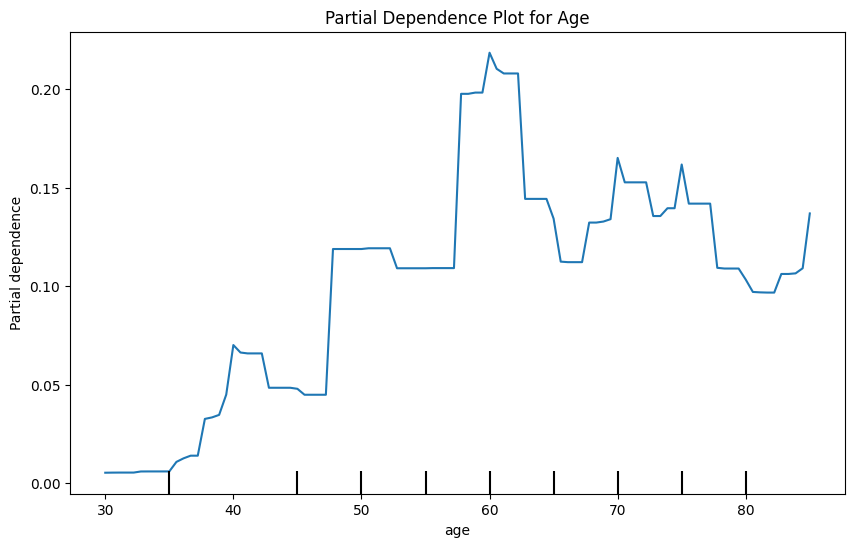

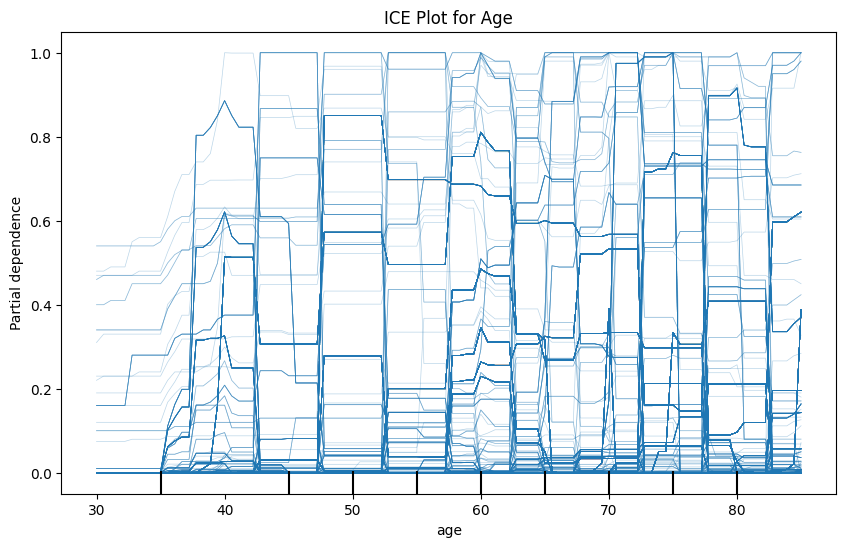

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# PDP for a specific feature (e.g., 'age')
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(clf, X_train_res, features=['age'], ax=ax, target=0)
ax.set_title('Partial Dependence Plot for Age')
plt.show()

# ICE for the same feature (e.g., 'age')
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(clf, X_train_res, features=['age'], kind='individual', ax=ax, target=0)
ax.set_title('ICE Plot for Age')
plt.show()

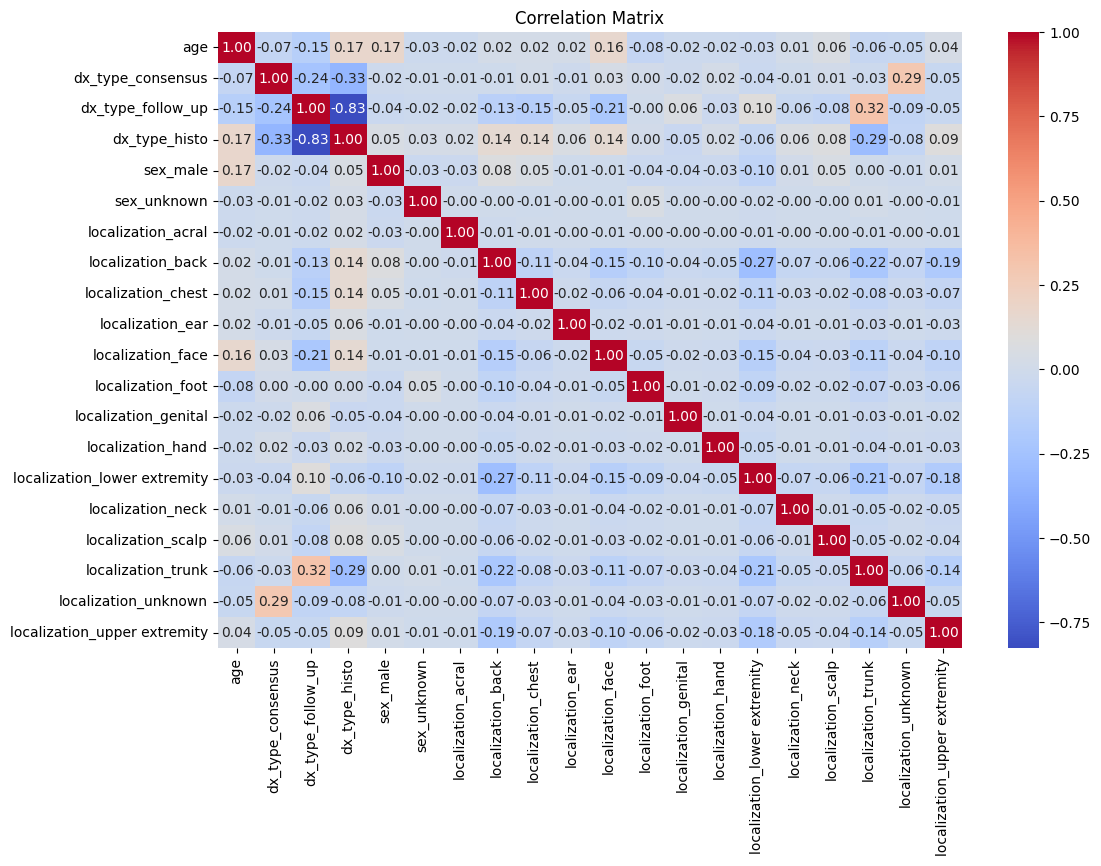

In [ ]:
# Compute correlation matrix
corr_matrix = X.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


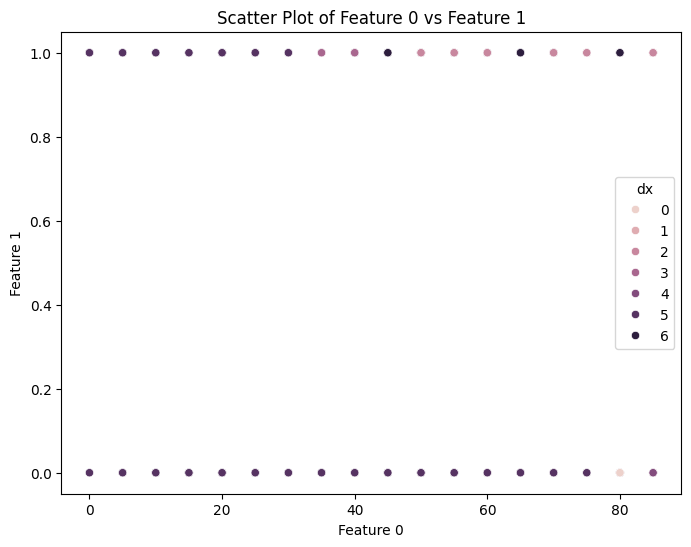

In [ ]:
# Scatter plot for two features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test.iloc[:, 0], y=X_test.iloc[:, 1], hue=y_test)
plt.title('Scatter Plot of Feature 0 vs Feature 1')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()


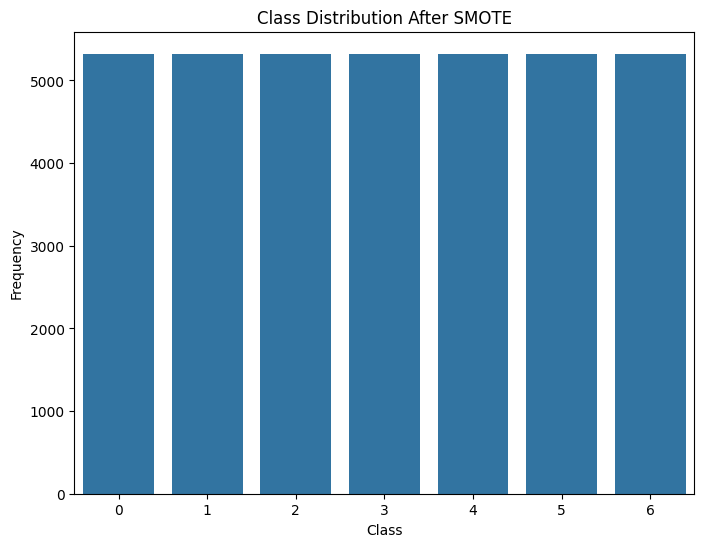

In [ ]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()
